# Comparison of 5 batches of classification with my Chat GPT Classification

## Installing libraries

In [104]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

## Uploading all the data

In [76]:
with open("results_booking_reviews_678_varlen_clean.json", "r") as f:
    results_data = json.load(f)

# given model classification results
df_results = [
    pd.DataFrame(results_data["gemini-2.5-flash"][i])
    for i in range(5)
]

# my classification results
gpt_results_data = []
for i in range(5):
    filename = f"gpt_classification_results[{i+1}].json"
    with open(filename, "r") as f:
        gpt_results_data.append(json.load(f))

df_gpt_results = [pd.DataFrame(data) for data in gpt_results_data]

In [77]:
df_results_updated = []

for i in range(5):
    df_results_i = df_results[i].copy()
    df_gpt_results_i = df_gpt_results[i].copy()  # use the list here

    # Compute majority sentiment
    majority_sentiment = (
        df_gpt_results_i.groupby('subtopic')['sentiment']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
        .rename(columns={'sentiment': 'my_gpt_sentiment'})
    )

    # Merge into df_results_i
    df_results_i = df_results_i.merge(majority_sentiment, on='subtopic', how='left')

    df_results_updated.append(df_results_i)

df_results = df_results_updated  # replace the old list

In [78]:
comparison_df = []

for i in range(5):
    df_results_i = df_results[i]          # single df_results
    df_gpt_results_i = df_gpt_results[i]  # **do not overwrite the list!**

    # Prepare comparison data
    temp_comparison_df = df_results_i[['subtopic', 'percent', 'sentiment', 'my_gpt_sentiment']].copy()

    # Compute ChatGPT percent
    category_counts = df_gpt_results_i['subtopic'].value_counts()
    category_percent = (category_counts / len(df_gpt_results_i)) * 100
    category_percent = category_percent.reset_index()
    category_percent.columns = ['subtopic', 'gpt_percent']

    # Merge ChatGPT percentages into the comparison df
    temp_comparison_df = temp_comparison_df.merge(category_percent, on='subtopic', how='left')

    # Append to the list
    comparison_df.append(temp_comparison_df)

# Visual Comparison

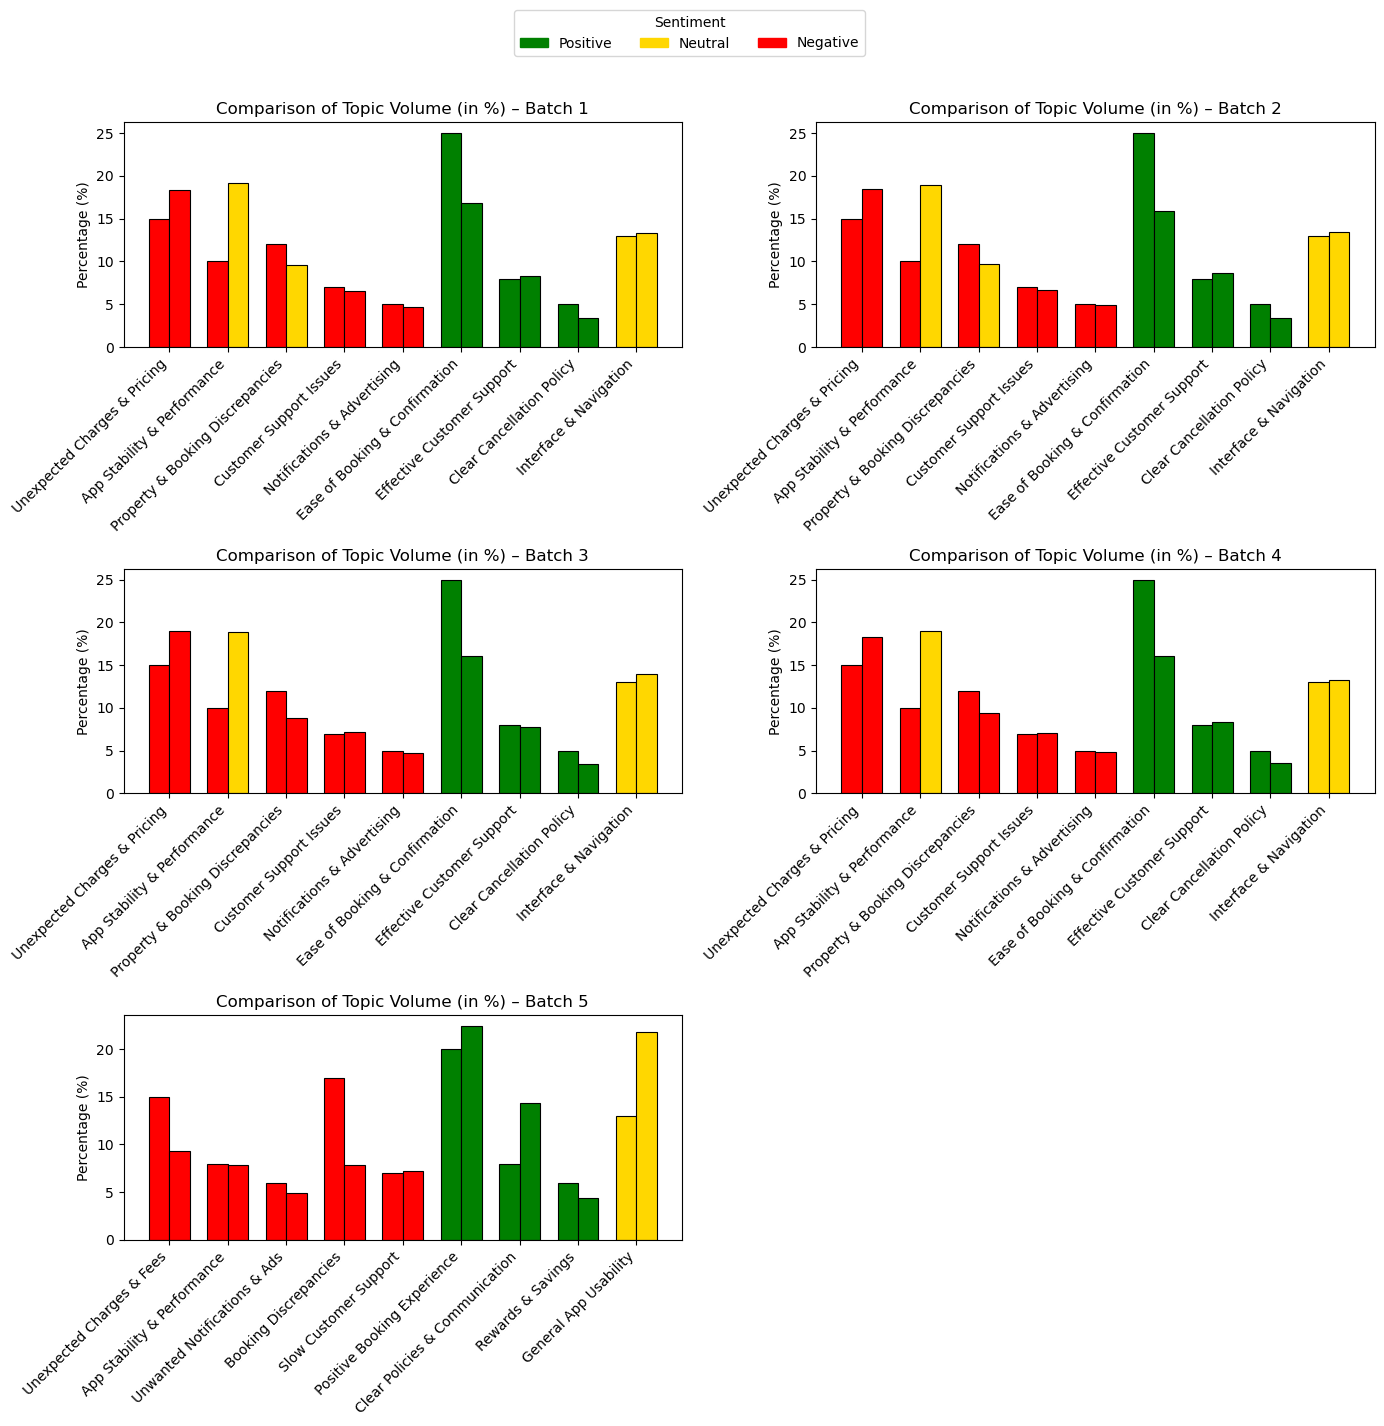

In [125]:
# Define sentiment colors
sentiment_colors = {
    'Positive': 'green',
    'Neutral': 'gold',
    'Negative': 'red'
}

bar_width = 0.35

# Create a 2x2 grid + 1 below → 3 rows, 2 columns
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

# We'll only use 5 of the 6 subplots
for i in range(5):
    ax = axes[i]

    # X positions
    x = range(len(comparison_df[i]))

    # Bar colors by sentiment
    orig_colors = [sentiment_colors[s] for s in comparison_df[i]['sentiment']]
    gpt_colors = [sentiment_colors[s] for s in comparison_df[i]['my_gpt_sentiment']]

    # Plot bars
    ax.bar([j - bar_width/2 for j in x],
           comparison_df[i]['percent'],
           width=bar_width,
           color=orig_colors,
           edgecolor='black',
           linewidth=0.8)

    ax.bar([j + bar_width/2 for j in x],
           comparison_df[i]['gpt_percent'],
           width=bar_width,
           color=gpt_colors,
           edgecolor='black',
           linewidth=0.8)

    # Labels and title
    ax.set_xticks(list(x))
    ax.set_xticklabels(comparison_df[i]['subtopic'], rotation=45, ha='right')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Comparison of Topic Volume (in %) – Batch {i+1}')

# Hide the unused 6th subplot (bottom right)
fig.delaxes(axes[-1])

# Create a single shared legend
legend_patches = [
    mpatches.Patch(color='green', label='Positive'),
    mpatches.Patch(color='gold', label='Neutral'),
    mpatches.Patch(color='red', label='Negative')
]
fig.legend(handles=legend_patches,
           title='Sentiment',
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 1.02))

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The first 4 plots do not differ in the given results_data, but they show that my own rerun of classification with Chat GPT is not fully consistent. Which is a bit surprising as we gave temperature = 0 to the Chat GPT prompt which promises us to avoid variability.

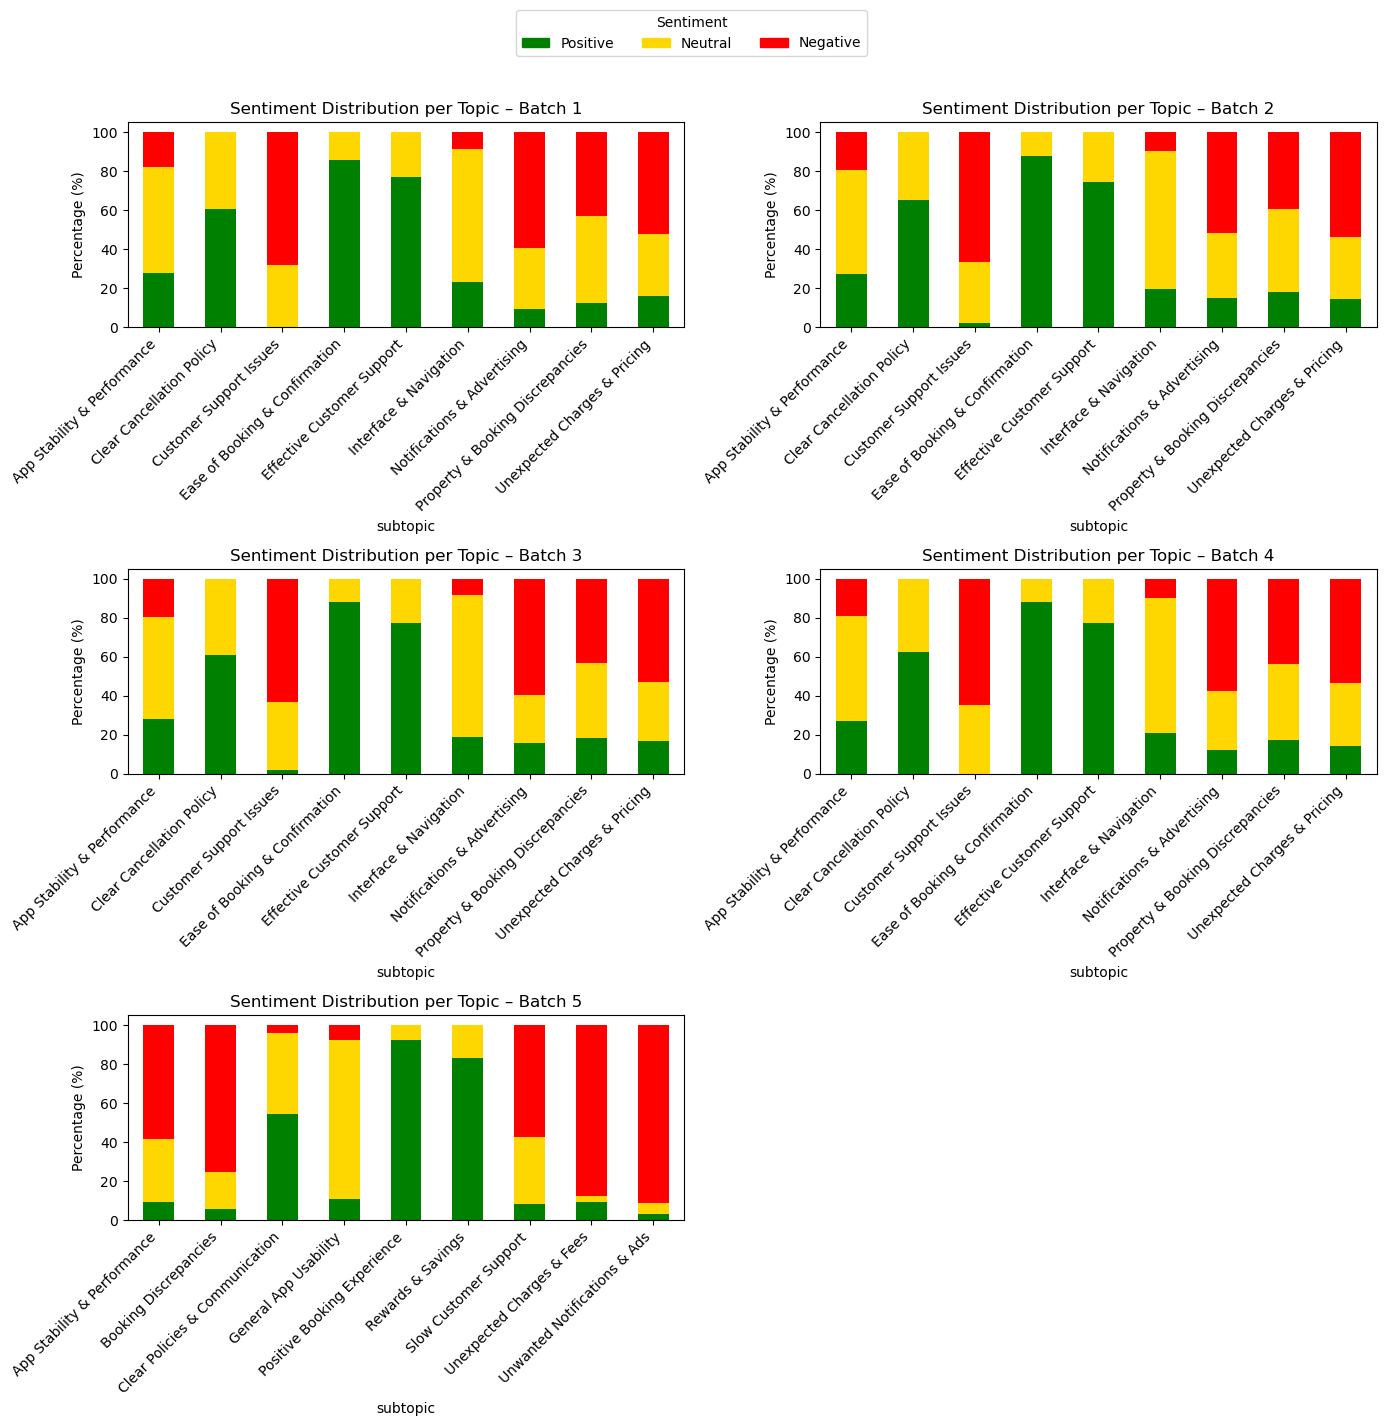

In [126]:
# Define sentiment colors
sentiment_colors = {
    'Positive': 'green',
    'Neutral': 'gold',
    'Negative': 'red'
}

# Create 3 rows x 2 cols grid → only 5 plots used
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]

    # 1. Calculate sentiment distribution per subtopic
    sentiment_dist = df_gpt_results[i].groupby(['subtopic', 'sentiment']).size().unstack(fill_value=0)
    sentiment_percent = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100

    # Ensure consistent order
    sentiment_percent = sentiment_percent[['Positive', 'Neutral', 'Negative']]

    # Plot stacked bar chart **without legend**
    sentiment_percent.plot(
        kind='bar',
        stacked=True,
        color=[sentiment_colors['Positive'], sentiment_colors['Neutral'], sentiment_colors['Negative']],
        ax=ax,
        legend=False  # <-- disable individual legend
    )

    # Labels and title
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Sentiment Distribution per Topic – Batch {i+1}')
    ax.set_xticklabels(sentiment_percent.index, rotation=45, ha='right')

# Remove the unused 6th subplot
fig.delaxes(axes[-1])

# Create a single shared legend
legend_patches = [
    mpatches.Patch(color='green', label='Positive'),
    mpatches.Patch(color='gold', label='Neutral'),
    mpatches.Patch(color='red', label='Negative')
]
fig.legend(handles=legend_patches,
           title='Sentiment',
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 1.02))

# Adjust spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Our inconsistencies in categories are for 2 categories in first 4 plots: App Stability & Performance and Property & Booking Discrepancies.
We see that for App Stability, we have prevailing neutral sentiment. However, for Property & Booking, Neutral and Negative sentiments are almost identical in proportion.

Personally, it is telling me that the idea of just choosing the sentiment of the most prevailing sentiment is not the best. I would rather use numerical values where (-1) goes for Negative, (0) for Neutral, and (+1) for Positive, and calculate average, which would have a form of a decimal number between -1 to +1.

Another conclusion we can make looking at the data is once "Property & Booking discrepancies" was divided into just "Booking discrepancies" (strong "negative" - around 70%) and "General App Usability" (strong "neutral" - more than 80%), it gave us clearer picture where the weaknesses lie for further decision making in introduction of changes.

# Quantitative Evaluation

## 1. Find average for rounds 1-4

Since the difference in batches 1-4 comes only from my evaluation (validation), there is no need to compare them between each other. Also, since we already have 4 results, why not ensure more precision utilizing this statistics. Therefore, let's find the values for batches 1-4 by averaging volumes/sentiment per topic.

For further analysis we need to convert "Negative"/"Neutral"/"Positive" values for numerical ones. Let's replace with -1/0/+1.

In [ ]:
num_comparison_df = []

# Define mapping dictionary
sentiment_map = {
    "Negative": -1,
    "Neutral": 0,
    "Positive": 1
}

for i in range(5):
    # Create a copy so the original combined_df stays unchanged
    combined_numeric_df = comparison_df[i].copy()

    # Replace values in both sentiment columns
    combined_numeric_df["sentiment"] = combined_numeric_df["sentiment"].replace(sentiment_map)
    combined_numeric_df["my_gpt_sentiment"] = combined_numeric_df["my_gpt_sentiment"].replace(sentiment_map)

    num_comparison_df.append(combined_numeric_df)

Now let's find the average:

In [82]:
# Concatenate the first four DataFrames
combined_df = pd.concat([num_comparison_df[i] for i in range(4)], ignore_index=True)

# Compute the mean of all numeric columns grouped by "Subtopic"
avg_df = combined_df.groupby("subtopic", as_index=False).mean()

num_comparison_df.append(avg_df)

## 2. Quantitative Metrics for Volume Validation

### 2.1 Total Absolute Difference

In [97]:
total_abs_diff_14 = (num_comparison_df[5]["percent"] - num_comparison_df[5]["gpt_percent"]).abs().sum()
print("Total absolute difference over all topics for batches 1-4:", round(total_abs_diff_14, 2))

total_abs_diff_5 = (num_comparison_df[4]["percent"] - num_comparison_df[4]["gpt_percent"]).abs().sum()
print("Total absolute difference over all topics for batch 5:", round(total_abs_diff_5, 2))

Total absolute difference over all topics for batches 1-4: 26.58
Total absolute difference over all topics for batch 5: 35.56


### 2.2 Mean Absolute Error

In [98]:
mae_14 = mean_absolute_error(num_comparison_df[5]["percent"], num_comparison_df[5]["gpt_percent"])
print("Mean Absolute Error for batches 1-4 over subtopics:", round(mae_14, 2))

mae_5 = mean_absolute_error(num_comparison_df[4]["percent"], num_comparison_df[4]["gpt_percent"])
print("Mean Absolute Error for batch 5 over subtopics:", round(mae_5, 2))

Mean Absolute Error for batches 1-4 over subtopics: 2.95
Mean Absolute Error for batch 5 over subtopics: 3.95


### 2.3 Root Mean Squared Error

In [99]:
rmse_14 = np.sqrt(np.mean((num_comparison_df[5]["percent"] - num_comparison_df[5]["gpt_percent"])**2))
print("Overall RMSE for batches 1-4:", round(rmse_14, 2))

rmse_5 = np.sqrt(np.mean((num_comparison_df[4]["percent"] - num_comparison_df[4]["gpt_percent"])**2))
print("Overall RMSE for batches 5:", round(rmse_5, 2))

Overall RMSE for batches 1-4: 4.47
Overall RMSE for batches 5: 5.21


### 2.4 Pearson Correlation

In [100]:
pearson_corr_14 = num_comparison_df[5]["percent"].corr(num_comparison_df[5]["gpt_percent"])
print("Pearson correlation between percent and gpt_percent for batches 1-4:", round(pearson_corr_14, 2))

pearson_corr_5 = num_comparison_df[4]["percent"].corr(num_comparison_df[4]["gpt_percent"])
print("Pearson correlation between percent and gpt_percent for batch 5:", round(pearson_corr_5, 2))

Pearson correlation between percent and gpt_percent for batches 1-4: 0.7
Pearson correlation between percent and gpt_percent for batch 5: 0.61


## 3. Quantitative Metrics for Sentiment Validation

### 3.1 Sentiment Agreement

In [101]:
# Compute overall average accuracy across all topics
overall_sentiment_accuracy_14 = (num_comparison_df[5]["sentiment"] == num_comparison_df[5]["my_gpt_sentiment"]).mean()
overall_sentiment_accuracy_5 = (num_comparison_df[4]["sentiment"] == num_comparison_df[4]["my_gpt_sentiment"]).mean()

print("Overall average accuracy across all topics for batches 1-4:", round(overall_sentiment_accuracy_14, 2))
print("Overall average accuracy across all topics for batch 5:", round(overall_sentiment_accuracy_5, 2))

Overall average accuracy across all topics for batches 1-4: 0.78
Overall average accuracy across all topics for batch 5: 1.0


### 3.2 F1-Score

F1-Score cannot interpret our -0.5 value, so we need to replace it with an integer. Let's replace with Neutral (0)

In [121]:
# Map fractional labels: treat 0.5 as 0
y_true_14_mapped = num_comparison_df[5]["sentiment"].replace({-0.5: 0}).round().astype(int)
y_pred_14_mapped = num_comparison_df[5]["my_gpt_sentiment"].replace({-0.5: 0}).round().astype(int)

# Compute F1-score
labels = [-1, 0, 1]  # all possible sentiment classes
f1_14 = f1_score(y_true_14_mapped, y_pred_14_mapped, labels=labels, average='macro')

print(f"F1-score for sentiment prediction for batches 1-4: {f1_14:.2f}")

# Extract true and predicted sentiment
y_true_5 = num_comparison_df[4]["sentiment"]
y_pred_5 = num_comparison_df[4]["my_gpt_sentiment"]

# Compute F1-score (macro average across all classes)
f1_5= f1_score(y_true_5, y_pred_5, labels=labels, average='macro')

print(f"F1-score for sentiment prediction for batch 5: {f1_5:.2f}")

F1-score for sentiment prediction for batches 1-4: 0.75
F1-score for sentiment prediction for batch 5: 1.00


### 3.3 Confusion Matrix

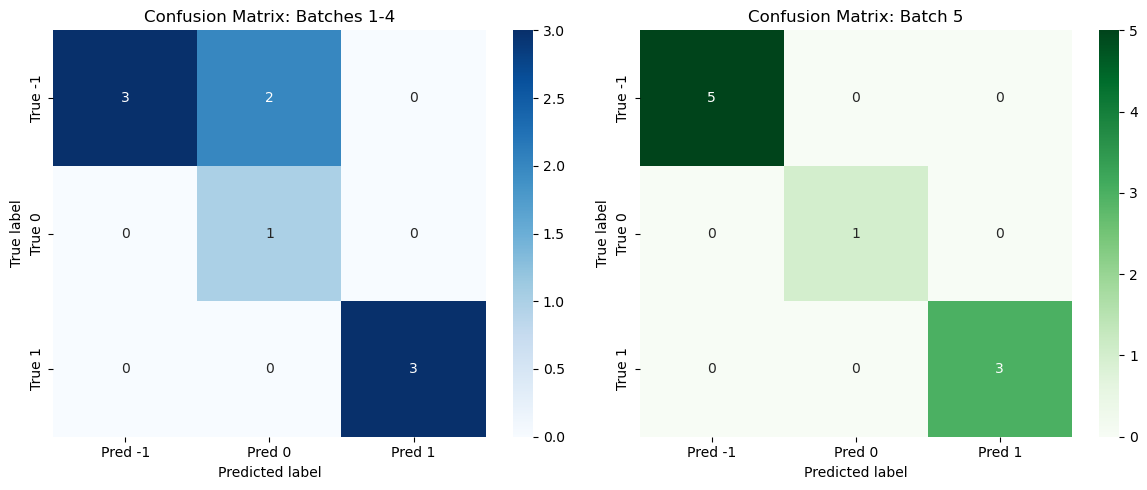

In [103]:
# Function to compute confusion matrix DataFrame
def get_cm_df(df):
    y_true = df["sentiment"].replace({-0.5: 0})
    y_pred = df["my_gpt_sentiment"].replace({-0.5: 0})
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    cm_df = pd.DataFrame(cm, index=["True -1", "True 0", "True 1"],
                         columns=["Pred -1", "Pred 0", "Pred 1"])
    return cm_df

# Compute confusion matrices
cm_left = get_cm_df(num_comparison_df[5])
cm_right = get_cm_df(num_comparison_df[4])

# Plot side by side
plt.figure(figsize=(12,5))

# Left
plt.subplot(1, 2, 1)
sns.heatmap(cm_left, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Batches 1-4")
plt.ylabel("True label")
plt.xlabel("Predicted label")

# Right
plt.subplot(1, 2, 2)
sns.heatmap(cm_right, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: Batch 5")
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.tight_layout()
plt.show()

## 4. Final Comparison

In [124]:
# Example table (your values will be inserted)
batches_1_4_values = [total_abs_diff_14, mae_14, rmse_14, pearson_corr_14, overall_sentiment_accuracy_14, f1_14]
batch_5_values    = [total_abs_diff_5, mae_5, rmse_5, pearson_corr_5, overall_sentiment_accuracy_5, f1_5]

table_data = {
    "Measure": [
        "Total Absolute Difference in Volumes (%)",
        "Mean Absolute Error in Volumes (%)",
        "Root Mean Squared Error in Volumes (%)",
        "Pearson Correlation of Volumes",
        "Sentiment Prediction Accuracy",
        "Sentiment F1-Score (Macro)"
    ],
    "Batches 1-4": batches_1_4_values,
    "Batch 5": batch_5_values
}

final_table_df = pd.DataFrame(table_data)

# Function to color rows
def color_rows(row):
    if row.name < 4:  # first 4 rows
        return ['background-color: #E0BBE4']*3  # light purple
    else:              # last 2 rows
        return ['background-color: #B2DFDB']*3  # light teal

# Display with colors and 2 decimals
display(
    final_table_df.style.apply(color_rows, axis=1)
                          .format({"Batches 1-4": "{:.2f}", "Batch 5": "{:.2f}"})
)

,Measure,Batches 1-4,Batch 5
0,Total Absolute Difference in Volumes (%),26.58,35.56
1,Mean Absolute Error in Volumes (%),2.95,3.95
2,Root Mean Squared Error in Volumes (%),4.47,5.21
3,Pearson Correlation of Volumes,0.70,0.61
4,Sentiment Prediction Accuracy,0.78,1.00
5,Sentiment F1-Score (Macro),0.75,1.00


# 5. Conclusion

Comparing numerical values, we can see now, that the first classification (batches 1-4) works better for volume estimation. At the same time, the second classification (batch 5), works better (perfect, in fact) for sentiment estimation.